# TILD (NVT) -- Lammps to Vasp (low convergence)

### Introduction

This notebook is an example of the 'ProtocolTILDNVTPar' job in pyiron_contrib, which can be used to find the free energy difference $\Delta F$ between two systems of atoms $\mathrm{A}$ and $\mathrm{B}$ in a canonical ($NVT$) ensemble, given by the formula,

$\Delta F_\mathrm{A\rightarrow B}(N, V, T) = \int_0^1 \langle U_\mathrm{B}(\lambda) - U_\mathrm{A}(\lambda) \rangle_{(\lambda, N, V, T)} d\lambda$,

where $\lambda$ is the coupling parameter and $U$ is the potential energy of the system.

#### Lammps to Vasp (low convergence)

Here, we find the free energy difference between a system using the Lammps calculator (as system $\mathrm{A}$) and the same system using the Vasp (low convergence) calculator (as system $\mathrm{B}$).

### Pre-job setup

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

from pyiron_atomistics import Project
import pyiron_contrib

In [2]:
# define project

pr = Project('tild_lammps_to_vasp')
pr.remove_jobs(recursive=True)

#### Inputs

In [4]:
# structure specific
element = 'Al'
crystal_structure = 'fcc'
supercell = 2
lammps_potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'
a = 4.073603  # obtained from calc_md at 300K using Lammps.

# vasp specific
vasp_mesh = [3]*3
vasp_encut = 250.
vasp_potential = 'Al'

# tild specific
temperature = 300.
n_lambdas = 3  # number of 'lambda'/integration points
n_steps = 4  # MD steps
thermalization_steps = 1  # number of steps to equilibrate the system for
sampling_steps = 1  # collect a 'sample' every 'sampling_period' steps 
convergence_steps = 2  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 0.1 meV 
overheat_fraction = 1.  # since this is a DFT-MD job, we set it to 1. For longer runs, set to 2.
time_step = 10.  # larger timestep too, since it is a DFT-MD job

# cluster specific
queue = 'cmti'
tild_cores = 6  # if running on the headnode, use 1! Otherwise, set to n_lambdas
tild_run_time = 144000  # in seconds

#### 0 K relaxation

In [5]:
pr_zero = pr.create_group('ionic_relaxation')

zero = pr_zero.create.job.Lammps('zero')
zero.structure = pr.create.structure.bulk(
    name=element, 
    crystalstructure=crystal_structure, 
    cubic=crystal_structure.lower() in ['fcc', 'bcc'],
    orthorhombic=crystal_structure.lower() in ['hcp']
).repeat(supercell)
n_atoms = len(zero.structure.positions)
zero.potential = potential
zero.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtain the lattice constant from MD)
zero.run()

zero_k_energy = zero.output.energy_pot[-1]

The job zero was saved and received the ID: 15275062


/u/rads/pyiron_repos/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/rads/pyiron_repos/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/rads/pyiron_repos/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/rads/pyiron_repos/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Return

### TILDNVT job

#### Reference jobs

The 'ProtocolTILDNVTPar' job takes 'reference jobs' for the systems $\mathrm{A}$ and $\mathrm{B}$ as inputs. Here, we specify system $\mathrm{A}$ as a 'Lammps' job. System $\mathrm{B}$ is a 'Vasp' job.

In [6]:
pr_tild = pr.create_group('tild_jobs')

# reference job A -> Lammps
ref_job_a = pr_tild.create_job(pr.job_type.Lammps, 'ref_job_a', delete_existing_job=True)
ref_job_a.structure = zero.get_structure().copy()
ref_job_a.potential = lammps_potential
ref_job_a.save()

# reference job B -> Vasp
ref_job_b = pr_tild.create_job(pr.job_type.Vasp, 'ref_job_b', delete_existing_job=True)
ref_job_b.structure = zero.get_structure().copy()
ref_job_b.set_kpoints(mesh=vasp_mesh)
ref_job_b.set_encut(encut=vasp_encut)
ref_job_b.interactive_prepare()
# ref_job_b.server.run_mode.interactive = True  # gives an error if the following 2 lines are not run!
# ref_job_b._run_if_new()
ref_job_b.save()

The job ref_job_a was saved and received the ID: 15275063
The job ref_job_b was saved and received the ID: 15275064


#### Submit and run the job

In [7]:
tild_job = pr_tild.create_job(pr.job_type.ProtoTILDPar, 'tild_job')

# Tip: The documentation for the job can be accessed by running 'tild_job?' after the job has been defined!
    
tild_job.input.temperature = temperature
tild_job.input.ref_job_a_full_path = ref_job_a.path
tild_job.input.ref_job_b_full_path = ref_job_b.path
tild_job.input.n_lambdas = n_lambdas
tild_job.input.n_steps = n_steps
tild_job.input.thermalization_steps = thermalization_steps
tild_job.input.sampling_steps = sampling_steps
tild_job.input.convergence_check_steps = convergence_steps
tild_job.input.fe_tol = fe_tol
tild_job.input.time_step = time_step
tild_job.input.overheat_fraction = overheat_fraction

# # in addition to these inputs, you can also modify the following inputs
# tild_job.input.lambda_bias = 0.5
# tild_job.input.temperature_damping_timescale = 100.
# tild_job.input.cutoff_factor = 0.5
# tild_job.input.use_reflection = False
# tild_job.input.zero_k_energy = 0. # incase you want to provide an energy offset to the HessianJob

# # set this only if you're running this on your local PC, and/or using MySQL as your DB manager
# tild_job.input.sleep_time = 0.1  

# cluster inputs
tild_job.server.cores = tild_cores
# tild_job.server.queue = queue
# tild_job.server.run_time = tild_run_time

# run_job
tild_job.run()

The job tild_job was saved and received the ID: 15275065
The job create_jobs_a_0 was saved and received the ID: 15275066
The job create_jobs_a_1 was saved and received the ID: 15275067
The job create_jobs_a_2 was saved and received the ID: 15275068
The job create_jobs_b_0 was saved and received the ID: 15275069
The job create_jobs_b_1 was saved and received the ID: 15275070
The job create_jobs_b_2 was saved and received the ID: 15275071


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."


Convergence not reached in 2 steps. Continuing run...


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."


Maximum steps (4) reached. Stopping run.


#### Load the job

In [8]:
if tild_job.status == 'finished':
    path = Project(str(pr.base_name) + '/' + str(pr_tild.base_name))
    tild_job = path.load(tild_job.job_name)  # here we load
    print('job loaded')
else:
    print('job still running')

job loaded


#### Collect output

In [9]:
total_steps = tild_job.output.total_steps[-1]
lambdas = tild_job.output.lambdas[-1]
temperature_mean = tild_job.output.temperature_mean[-1]
temperature_std = tild_job.output.temperature_std[-1]
integrands = tild_job.output.integrands[-1]
integrands_std = tild_job.output.integrands_std[-1]
integrands_n_samples = tild_job.output.integrands_n_samples[-1]
del_A_tild = tild_job.output.tild_free_energy_mean[-1]  # A, because this is the Helmholtz free energy
del_A_tild_std = tild_job.output.tild_free_energy_std[-1]
del_A_tild_se = tild_job.output.tild_free_energy_se[-1]

# also records output using free energy perturbation method 
del_A_fep = tild_job.output.fep_free_energy_mean[-1]
del_A_fep_std = tild_job.output.fep_free_energy_std[-1]
del_A_fep_se = tild_job.output.fep_free_energy_se[-1]

# NOTE: The Helmholtz free energy from the FEP method returns a non-nan value, only if the systems A and B are 
# very close in potential energy to each other!

#### View output

In [10]:
# Check average temperature of the lambda points

print('mean temperature: {} K'.format(np.mean(temperature_mean)))

mean temperature: 203.91582539392718 K


Lambdas:  [0.  0.5 1. ]
Integrands plot: 


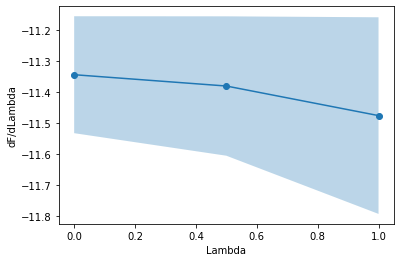

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Lambda', ylabel='dF/dLambda'>)

In [11]:
# Some inbuilt functions

print('Lambdas: ', tild_job.get_lambdas())
print('Integrands plot: ')
tild_job.plot_tild_integrands()

In [12]:
# Helmholtz free energy between the 2 systems using TILD and FEP

print('del_A_tild: {} eV'.format(del_A_tild))  # * 1e3 to convert it to meV
print('del_A_fep: {} eV'.format(del_A_fep))

del_A_tild: -11.390898353401894 eV
del_A_fep: -12.096815101095554 eV


In [13]:
# total free energy of system (Vasp)

A_tild = -3.415503241410667  # eV/atom, from notebook 'protocol_tild_harmonic_to_eam_example.ipynb'
A_tild_dft_per_atom = A_tild + (del_A_tild / n_atoms)
A_fep_dft_per_atom = A_tild + (del_A_fep / n_atoms)
print('A_tild_dft_per_atom: {} eV/atom'.format(A_tild_dft_per_atom))
print('A_fep_dft_per_atom: {} eV/atom'.format(A_fep_dft_per_atom))

A_tild_dft_per_atom: -3.7714688149544764 eV/atom
A_fep_dft_per_atom: -3.7935287133199034 eV/atom
